# Autocorrelation and Crosscorrelation
**Autocorrelation** measures the similarity between a time series and a lagged version of itself over successive time intervals. It helps in identifying repeating patterns or periodic signals within the data. 

**Crosscorrelation**, on the other hand, measures the similarity between two different time series as a function of the lag of one relative to the other. 

In the context of SSA, these metrics are useful for analysing the underlying structure and relationships within simulated time series data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from utils.load_data import load_and_split_data
from utils.steady_state import find_steady_state
from utils.steady_state import save_steady_state
from stats.autocorrelation import autocrosscorr
from stats.report import statistical_report
from visualisation.plots import *

%load_ext autoreload
%autoreload 2

To measure the autocorrelation, we take some example data

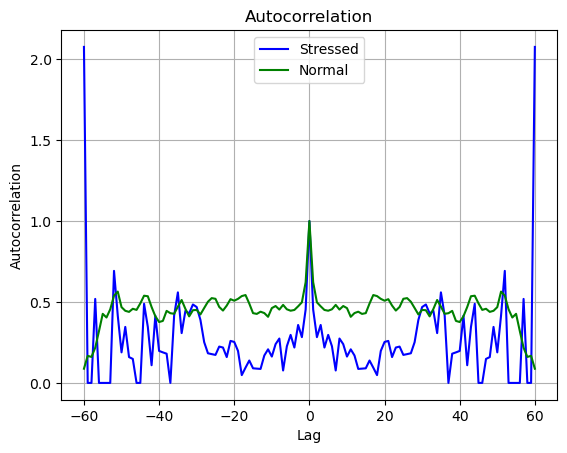

In [2]:
# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 0.12

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

output_file = "data/mRNA_trajectories_example.csv"
df_results = pd.read_csv(output_file)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# Find the time index at which steady state is reached
steady_state_time_stress, steady_state_index_stress = find_steady_state(parameter_sets[0])
steady_state_time_normal, steady_state_index_normal = find_steady_state(parameter_sets[1])

# Extract steady-state portions
steady_state_traj_stress = stress_trajectories[:, steady_state_index_stress:]
steady_state_traj_normal = normal_trajectories[:, steady_state_index_normal:]

ac_stress, lags_stress = autocrosscorr(yA=steady_state_traj_stress)
ac_normal, lags_normal = autocrosscorr(yA=steady_state_traj_normal)
plt.figure()
plt.plot(lags_stress, np.nanmean(ac_stress, axis=0), color="blue", label="Stressed")
plt.plot(lags_normal, np.nanmean(ac_normal, axis=0), color="green", label="Normal")
plt.legend()
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation")
plt.grid()
plt.show()

One-liner

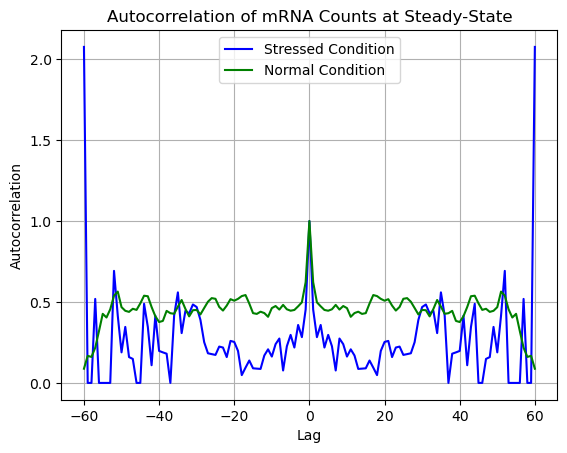

In [3]:
plot_autocorr(parameter_sets, stress_trajectories, normal_trajectories)

Cross-correlation between 2 signals

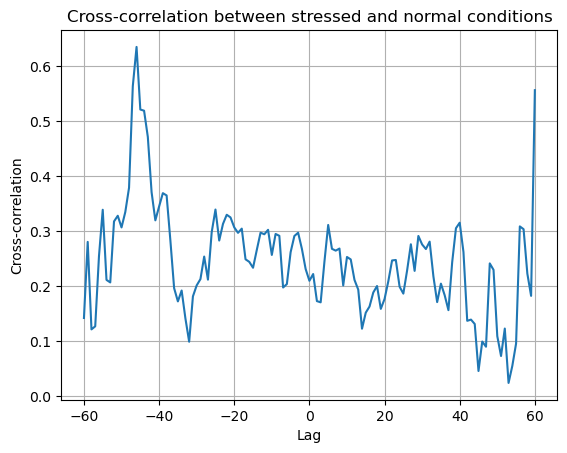

In [4]:
# Find and plot the cross-correlation between the two conditions
ac, lags = autocrosscorr(yA=steady_state_traj_normal, yB=steady_state_traj_stress)
plt.figure()
plt.plot(lags, np.nanmean(ac, axis=0))
plt.xlabel("Lag")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlation between stressed and normal conditions")
plt.grid()
plt.show()

One-liner 

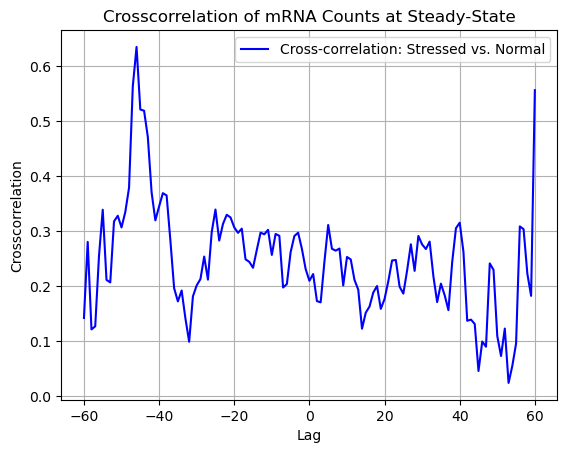

In [6]:
plot_crosscorr(parameter_sets,normal_trajectories,stress_trajectories)

## Fixing autocorrelation of a synthetic time series based on system parameters
Get the autocorrelation based on system parameters, based on the equation:

$\displaystyle ACmRNA = \frac{\left(d \rho \sigma_{u} e^{t \left(d - \sigma_{b} - \sigma_{u}\right)} - \left(\sigma_{b} + \sigma_{u}\right) \left(- d^{2} + \rho \sigma_{u} + \left(\sigma_{b} + \sigma_{u}\right)^{2}\right)\right) e^{- d t}}{\left(d - \sigma_{b} - \sigma_{u}\right) \left(d \left(\sigma_{b} + \sigma_{u}\right) + \rho \sigma_{u} + \left(\sigma_{b} + \sigma_{u}\right)^{2}\right)}$

Fixing mean, var, and autocorr

In [7]:
###### Fix the mean, var and autocorr values for the two conditions
import sympy as sp
from sympy import init_printing
from scipy.optimize import fsolve
import numpy as np

# Define symbols
rho, mu, sigma_sq, d, sigma_u, sigma_b, t = sp.symbols(
    'rho mu sigma_sq d sigma_u sigma_b t', real=True, positive=True
)
init_printing(use_unicode=True)

# Equation system
def equations(vars, sigma_u, mu_target, variance_target, autocorr_target):
    rho, sigma_b, d = vars

    # Mean
    mean_eqn = sigma_b * rho / (d * (sigma_b + sigma_u))

    # Variance
    variance_eqn = (
        sigma_b * rho / (d * (sigma_b + sigma_u)) +
        ((sigma_u * sigma_b) * rho**2 / (d * (sigma_b + sigma_u + d) * (sigma_u + sigma_b)**2))
    )

    # Autocorrelation
    ACmRNA_eq = sp.exp(-d * t) * (
        d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
        - (sigma_u + sigma_b) * (-d**2 + rho * sigma_u + (sigma_u + sigma_b) ** 2)
    ) / (
        (d - sigma_u - sigma_b) * (rho * sigma_u + d * (sigma_u + sigma_b) + (sigma_u + sigma_b) ** 2)
    )
    autocorr_eqn = ACmRNA_eq.subs(t, 1)

    eq1 = mean_eqn - mu_target
    eq2 = variance_eqn - variance_target
    eq3 = autocorr_eqn - autocorr_target

    return [float(eq1), float(eq2), float(eq3)]

# Jacobian
def jacobian(vars, sigma_u, mu_target, variance_target, autocorr_target):
    rho_val, sigma_b_val, d_val = vars
    rho_sym, sigma_b_sym, d_sym = sp.symbols('rho sigma_b d', real=True, positive=True)

    # Define expressions symbolically
    mean_eqn = sigma_b_sym * rho_sym / (d_sym * (sigma_b_sym + sigma_u))
    variance_eqn = (
        sigma_b_sym * rho_sym / (d_sym * (sigma_b_sym + sigma_u)) +
        ((sigma_u * sigma_b_sym) * rho_sym**2 / (d_sym * (sigma_b_sym + sigma_u + d_sym) * (sigma_u + sigma_b_sym)**2))
    )
    ACmRNA_eq = sp.exp(-d_sym * t) * (
        d_sym * sp.exp((d_sym - sigma_u - sigma_b_sym) * t) * rho_sym * sigma_u
        - (sigma_u + sigma_b_sym) * (-d_sym**2 + rho_sym * sigma_u + (sigma_u + sigma_b_sym)**2)
    ) / (
        (d_sym - sigma_u - sigma_b_sym) * (rho_sym * sigma_u + d_sym * (sigma_u + sigma_b_sym) + (sigma_u + sigma_b_sym)**2)
    )
    autocorr_eqn = ACmRNA_eq.subs(t, 1)

    # System
    eqs = [
        mean_eqn - mu_target,
        variance_eqn - variance_target,
        autocorr_eqn - autocorr_target
    ]
    
    J = sp.Matrix(eqs).jacobian([rho_sym, sigma_b_sym, d_sym])
    J_func = sp.lambdify((rho_sym, sigma_b_sym, d_sym), J, "numpy")

    return np.array(J_func(rho_val, sigma_b_val, d_val)).astype(np.float64)

# Targets
autocorr_target = 0.5
variance_target = 100.0
mu_target = 90.0

# Conditions
parameters = {
    "stress": {"sigma_u": 5.0},
    "normal": {"sigma_u": 2.5}
}

# Solution containers
rho_values = {}
sigma_b_values = {}
d_values = {}

# Sampling ranges
num_guesses = 500
rho_range = (1, 1000)
sigma_b_range = (0.1, 1000)
d_range = (0.1, 5)

for condition, param_set in parameters.items():
    sigma_u_val = param_set["sigma_u"]

    # Generate random initial guesses
    rho_guesses = np.random.uniform(*rho_range, num_guesses)
    sigma_b_guesses = np.random.uniform(*sigma_b_range, num_guesses)
    d_guesses = np.random.uniform(*d_range, num_guesses)
    initial_guesses = list(zip(rho_guesses, sigma_b_guesses, d_guesses))

    found = False
    for initial_guess in initial_guesses:
        try:
            solution = fsolve(
                equations, initial_guess,
                args=(sigma_u_val, mu_target, variance_target, autocorr_target),
                fprime=jacobian,
                xtol=1e-8
            )
            residuals = equations(solution, sigma_u_val, mu_target, variance_target, autocorr_target)
            residuals = np.abs(residuals)

            if all(res < 1e-4 for res in residuals) and all(x > 0 for x in solution):
                print(f"[{condition.upper()}] ✅ Found solution: {solution}")
                rho_values[condition] = solution[0]
                sigma_b_values[condition] = solution[1]
                d_values[condition] = solution[2]
                found = True
                break
        except Exception as e:
            continue

    if not found:
        print(f"[{condition.upper()}] ❌ No suitable solution found.")

# Output
print("\n--- Final Parameter Estimates ---")
print("Rho:", rho_values)
print("Sigma_b:", sigma_b_values)
print("d:", d_values)

# Updated Parameter Sets using the calculated rho values
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": sigma_b_values["stress"], 
     "rho": rho_values["stress"], 
     "d": d_values["stress"], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": sigma_b_values["normal"], 
     "rho": rho_values["normal"], 
     "d": d_values["normal"], 
     "label": 1}
]
print(parameter_sets)

[STRESS] ✅ Found solution: [68.71499908 50.26120276  0.69441898]


/tmp/ipykernel_247397/198821957.py:27: RuntimeWarning: invalid value encountered in multiply
  ACmRNA_eq = sp.exp(-d * t) * (
/tmp/ipykernel_247397/198821957.py:28: RuntimeWarning: invalid value encountered in multiply
  d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
/tmp/ipykernel_247397/198821957.py:106: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(


[NORMAL] ✅ Found solution: [66.8983275  35.95112955  0.69498621]

--- Final Parameter Estimates ---
Rho: {'stress': 68.7149990819378, 'normal': 66.89832750083563}
Sigma_b: {'stress': 50.26120276369069, 'normal': 35.95112955303022}
d: {'stress': 0.6944189753067186, 'normal': 0.6949862120279453}
[{'sigma_u': 5.0, 'sigma_b': 50.26120276369069, 'rho': 68.7149990819378, 'd': 0.6944189753067186, 'label': 0}, {'sigma_u': 2.5, 'sigma_b': 35.95112955303022, 'rho': 66.89832750083563, 'd': 0.6949862120279453, 'label': 1}]


Use the modularised codes

In [ ]:
from simulation.mean_var_autocorr import find_parameters

# Targets
mu_target = 150.0
variance_target = 500.0
autocorr_target = 1 / np.exp(1)  # autocorr at lag 1 is

# Example usage
parameters = {
    "stress": {"sigma_u": 5.0, "sigma_b": 50, "rho": 68.7,"d": 1.0},
    "normal": {"sigma_u": 2.5, "sigma_b": 35, "rho": 66.0, "d": 1.0}
}

results = {}
for label, param in parameters.items():
    try:
        #TODO: Only fix mean and autocorrelation
        # rho, d = find_parameters(param, mu_target=mu_target, autocorr_target=autocorr_target)

        #TODO: Only fix variance
        # sigma_b = find_parameters(param, variance_target=200.0)

        # # Fix all three
        rho, sigma_b, d = find_parameters(
            param, mu_target, variance_target, autocorr_target
        )

        results[label] = {"rho": rho, "sigma_b": sigma_b, "d": d}
        print(f"[{label.upper()}] ✅ Found: {results[label]}")
    except ValueError as e:
        print(f'{e}')
        print(f"[{label.upper()}] ❌ No suitable solution found.")


# update parameter sets 
parameter_sets = [
    {"sigma_u": parameters["stress"]["sigma_u"], 
     "sigma_b": results["stress"]['sigma_b'], 
     "rho": results["stress"]['rho'], 
     "d": results["stress"]['d'], 
     "label": 0},
     
    {"sigma_u": parameters["normal"]["sigma_u"], 
     "sigma_b": results["normal"]['sigma_b'], 
     "rho": results["normal"]['rho'], 
     "d": results["normal"]['d'], 
     "label": 1}
]
print(parameter_sets)

Attempt 1/10


/home/ianyang/stochastic_simulations/src/simulation/mean_var_autocorr.py:32: RuntimeWarning: invalid value encountered in multiply
  ACmRNA_eq = sp.exp(-d * t) * (
/home/ianyang/stochastic_simulations/src/simulation/mean_var_autocorr.py:33: RuntimeWarning: invalid value encountered in multiply
  d * sp.exp((d - sigma_u - sigma_b) * t) * rho * sigma_u
/home/ianyang/stochastic_simulations/src/simulation/mean_var_autocorr.py:166: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(


[STRESS] ✅ Found: {'rho': 205.70872090303828, 'sigma_b': 15.483421815895612, 'd': 1.0366350328164393}
Attempt 1/10
[NORMAL] ✅ Found: {'rho': 193.24208011047654, 'sigma_b': 11.370703991742253, 'd': 1.056086022798751}
[{'sigma_u': 5.0, 'sigma_b': 15.483421815895612, 'rho': 205.70872090303828, 'd': 1.0366350328164393, 'label': 0}, {'sigma_u': 2.5, 'sigma_b': 11.370703991742253, 'rho': 193.24208011047654, 'd': 1.056086022798751, 'label': 1}]


Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 5.0, 'sigma_b': 15.483421815895612, 'rho': 205.70872090303828, 'd': 1.0366350328164393, 'label': 0}


Simulating Telegraph Model Systems:  50%|█████     | 1/2 [01:34<01:34, 94.90s/it]

Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 2.5, 'sigma_b': 11.370703991742253, 'rho': 193.24208011047654, 'd': 1.056086022798751, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [03:15<00:00, 97.52s/it]



=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 9.6 min):
    - Mean mRNA Count: 149.84
    - Variance: 495.98

  Normal Condition (after 9.5 min):
    - Mean mRNA Count: 149.75
    - Variance: 502.36


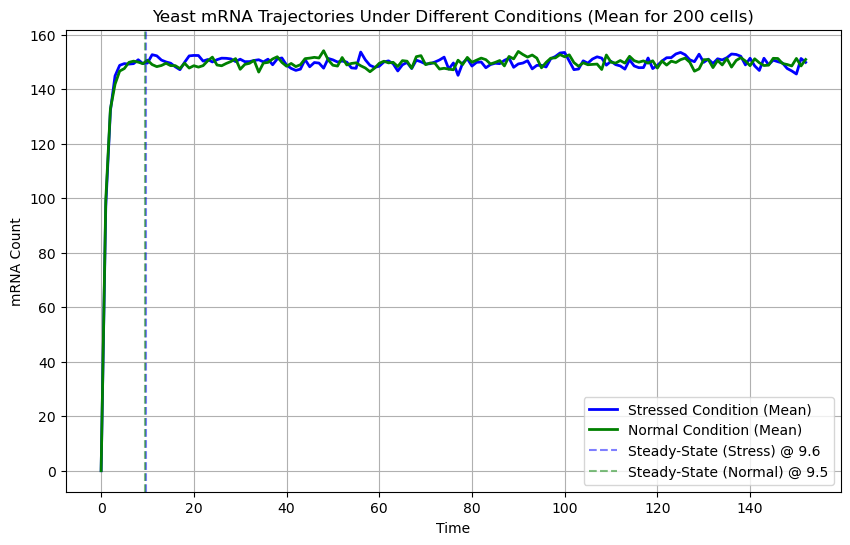

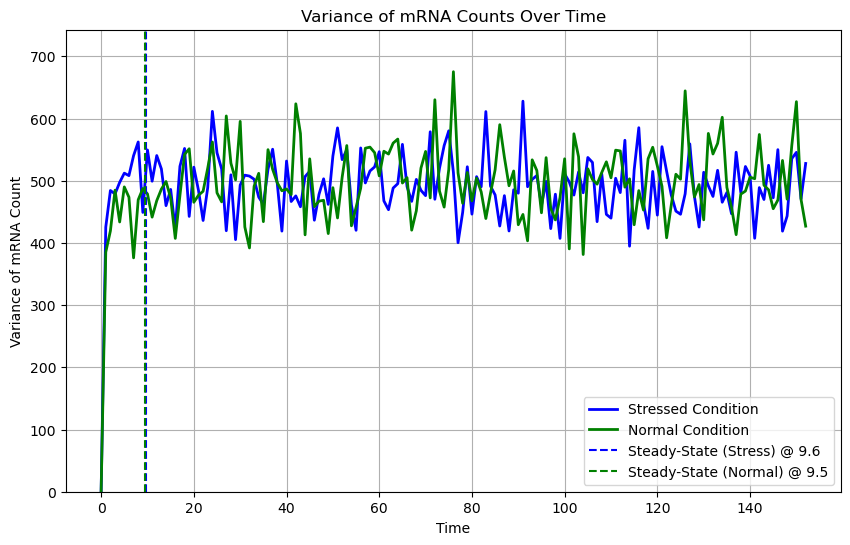


=== Variance at Steady State ===
  Stressed Condition (after 9.6 min): Mean = 149.84, Variance = 495.98
  Normal Condition (after 9.5 min): Mean = 149.75, Variance = 502.36


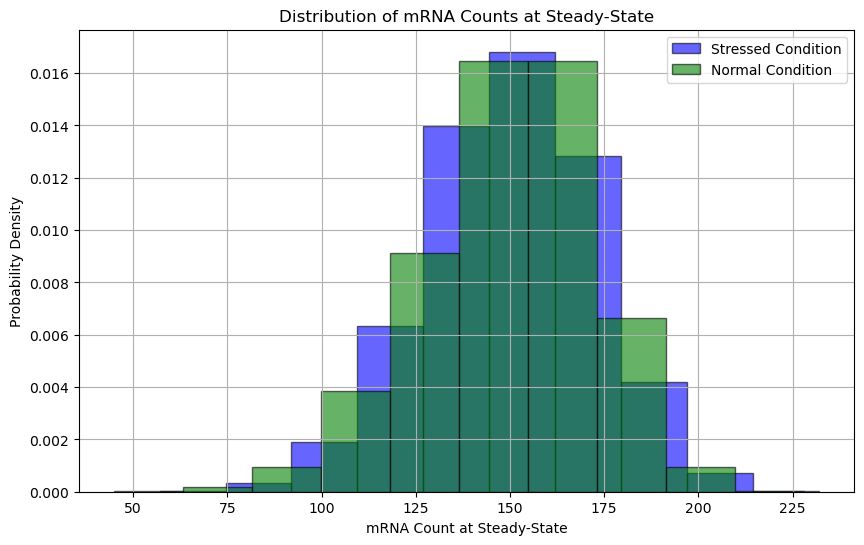

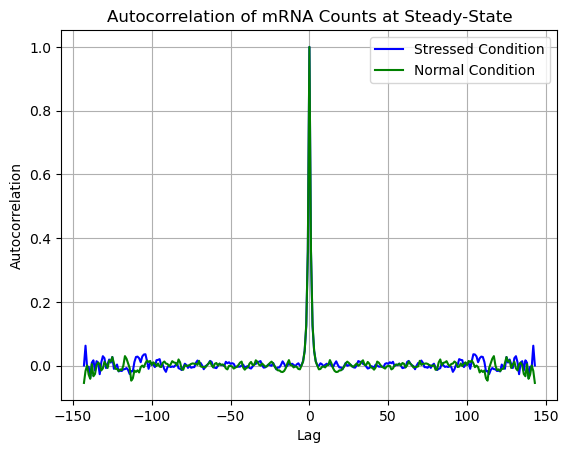

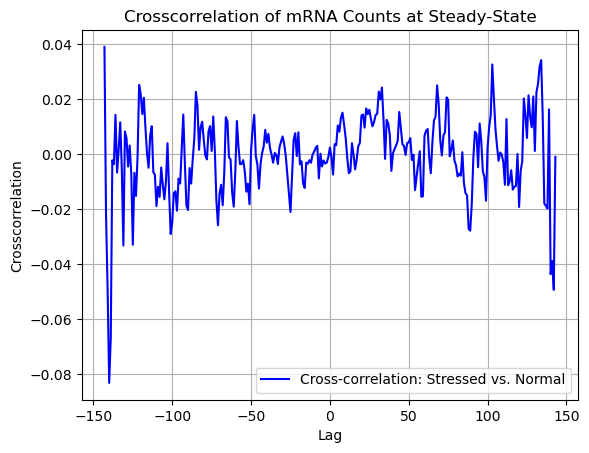

In [9]:
############# SIMULATION ################

# Set up simulation parameters 
# get the min degradation rate
min_d = min([param_set['d'] for param_set in parameter_sets])    
# get the time point after which the system reaches steady state 
steady_state_time = int(10 / min_d)

# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points
# extend time points to account for steady state
extended_time_points = np.arange(time_points[0], 
                                 len(time_points) + steady_state_time, 
                                 time_points[1] - time_points[0])

size = 200  # size of the simulation needs to be big enough for this particular system to reach steady state

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, extended_time_points, size)

# Save dataset for ML classification
output_file = f"data/mRNA_trajectories_auto_mu_var_fixed_{autocorr_target}_{mu_target}_{variance_target}.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report =  statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

# Plots
plot_mRNA_trajectory(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_variance(parameter_sets, extended_time_points, stress_trajectories, normal_trajectories)
plot_mRNA_dist(parameter_sets, stress_trajectories, normal_trajectories)
plot_autocorr(parameter_sets, stress_trajectories, normal_trajectories)
plot_crosscorr(parameter_sets, normal_trajectories, stress_trajectories)